In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.cluster.hierarchy as sch
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import norm
from scipy.optimize import minimize

df = pd.read_csv("./Clean/clean-huf-spy-6.csv")
df = df.drop(columns=['Unnamed: 0'])
df.set_index('Dátum', inplace=True)
df = df[::-1]
df = df[df.index >= '2018-03-09']
annual_risk_free_rate = 0.05
daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/252) - 1

benchmark = 'S&P 500'
# benchmark = 'USDHUF=X'
interesting = ['Citadella_Származtatott_Relative_Return', 'Erste_Stock_Hungary_Indexkövető_Részvény_A_Relative_Return',
               'SP500_Relative_Return', 'HOLD_Nemzetközi_Relative_Return', 'OTP_Supra_Relative_Return', 'HOLD_Columbus_Relative_Return']
# Create a dictionary to rename the columns to something simpler

rename_dict = {
    'Citadella_Származtatott': 'Citadella',
    'Erste_Stock_Hungary_Indexkövető_Részvény_A': 'Erste Indexkövető',
    'Generali_Arany_Oroszlán_ESG': 'Generali ESG',
    'HOLD_Columbus': 'HOLD Columbus',
    'HOLD_Nemzetközi': 'HOLD Nemzetközi',
    'HOLD_VM_Abszolút_Származtatott_Befektetési': 'HOLD Abszolút',
    'MBH_Fejlett_Piaci_Részvény': 'MBH Fejlett Piaci',
    'OTP_Klímaváltozás_13030': 'OTP Klímaváltozás',
    'OTP_Supra': 'OTP Supra',
    'VIG_Opportunity_Fejlett_Piaci_Részvény': 'VIG Opportunity',
    'Accorde_Abacus_Alap': 'Accord Abacus',
    'Accorde_Prizma_Alap': 'Accord Prizma',
    'HOLD_Orion': 'HOLD Orion',
    'OTP Föld Kincsei Árupiaci Alapok Alapja HUF': 'OTP Föld Kincsei',
    'Platina Delta Származtatott Befektetési Alap A':'Platina Delta',
    'Raiffeisen Részvény Alap':'Raiffeisen Részvény',
    'Takarék Származtatott Befektetési Alap': 'Gránit Takarék',
    'TakarékApolloSzármaztatottRészvény': 'Gránit Apollo',
    'SPY': 'S&P 500',
}

df_relative_returns = df.copy()
relative_return_columns = []
for column in df_relative_returns.columns:
    new_column = column + '_'
    df_relative_returns[column] = df_relative_returns[column] / df_relative_returns[column].iloc[0]
    
df=df_relative_returns
# df=df_relative_returns
df = df.rename(columns=rename_dict)

daily_returns = df.pct_change().dropna()


In [81]:
fee_structure = {
    "Gránit Apollo": {
        "entry_fee_percent": 3.0,
        "exit_fee_percent": 3.0,
        "management_fee_percent": 1.97
    },
    "Erste Indexkövető": {
        "entry_fee_percent": 2.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 0.99,
        "portfolio_transaction_fee_percent": 0.26
    },
    "Generali ESG": {
        "entry_fee_percent": 3.0,
        "exit_fee_percent": 1.5,
        "management_fee_percent": 1.95,
        "transaction_fee_percent": 0.07,
        "performance_fee_percent": 0.0
    },
    "MBH Fejlett Piaci": {
        "entry_fee_percent": 2.22,
        "exit_fee_percent": 0.1,
        "management_fee_percent": 2.24,
        "transaction_fee_percent": 0.1,
        "performance_fee_percent": 0.0
    },
    "OTP Klímaváltozás": {
        "entry_fee_percent": 5.0,
        "exit_fee_percent": 5.0,
        "management_fee_percent": 2.14,
        "transaction_fee_percent": 0.3,
        "performance_fee_percent": 1.23
    },
    "OTP Supra": {
        "entry_fee_percent": 5.0,
        "exit_fee_percent": 5.0,
        "management_fee_percent": 2.21,
        "transaction_fee_percent": 0.84,
        "performance_fee_percent": 1.02
    },
    "HOLD Columbus": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 2.19,
        "transaction_fee_percent": 0.12,
        "performance_fee_percent": 0.02
    },
    "HOLD Nemzetközi": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 1.33,
        "transaction_fee_percent": 0.1,
        "performance_fee_percent": 0.0
    },
    "HOLD Abszolút": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 1.88,
        "transaction_fee_percent": 0.12,
        "performance_fee_percent": 0.67
    },
    "HOLD Orion": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 2.20,
        "transaction_fee_percent": 0.22,
        "performance_fee_percent": 0.01,
    },
    "VIG Opportunity": {  # bad
        "entry_fee_percent": 5.0,
        "exit_fee_percent": 3.5,
        "management_fee_percent": 1.92,
        "transaction_fee_percent": 0.11,
        "performance_fee_percent": 0.01,
    },
    "Accord Prizma": {
        "entry_fee_percent": 1.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 2.09,
        "transaction_fee_percent": 0.0002,
        "performance_fee_percent": 1.59,
    },
    "Platina Delta": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 2.20,
        "transaction_fee_percent": 0.22,
        "performance_fee_percent": 0.01,
    },
    "Citadella": {
    "entry_fee_percent": 0.0,
    "exit_fee_percent": 0.0,
    "management_fee_percent": 1.88,
    "transaction_fee_percent": 0.08,
    "performance_fee_percent": 1.55,
    "management_fee_huf": 75394,  # Estimated annual management fee
    "transaction_fee_huf": 3336,  # Estimated annual transaction fee
    "performance_fee_huf": 62000  # Estimated performance fee
    },
}


In [82]:
df['Citadella']

Dátum
2018-03-09    1.000000
2018-03-12    0.999769
2018-03-13    0.999737
2018-03-14    0.999947
2018-03-19    0.999093
                ...   
2024-08-08    1.561106
2024-08-09    1.562690
2024-08-12    1.570898
2024-08-13    1.565224
2024-08-14    1.567576
Name: Citadella, Length: 1544, dtype: float64

In [83]:
def apply_fees(df_returns, security_name):
    # Retrieve fees for the given security
    fees = fee_structure.get(security_name, None)
    if fees is None:
        raise ValueError(f"Fee structure for {security_name} not found.")

    # Apply entry transaction fee at the start
    entry_fee_percent = fees['entry_fee_percent'] / 100
    df_returns[security_name].iloc[0] -= entry_fee_percent
    print(f"Entry fee applied on {df_returns.index[0]}: {entry_fee_percent * 100}%")
    
    # Track the end of each year
    last_year = pd.to_datetime(df_returns.index[0], format='%Y-%m-%d').year
    
    for i in range(1, len(df_returns)):
        current_year = pd.to_datetime(df_returns.index[i], format='%Y-%m-%d').year
        
        # Apply fees only once per year
        if current_year != last_year:
            # Apply management fees
            management_fee_percent = fees['management_fee_percent'] / 100
            df_returns[security_name].iloc[i] -= management_fee_percent
            print(f"Management fee applied on {df_returns.index[i]}: {management_fee_percent * 100}%")
            
            # Apply performance fee if it exists and if the return is positive
            if 'performance_fee_percent' in fees and fees['performance_fee_percent'] > 0:
                performance_fee_percent = fees['performance_fee_percent'] / 100
                df_returns[security_name].iloc[i] -= performance_fee_percent
                print(f"Performance fee applied on {df_returns.index[i]}: {performance_fee_percent * 100}% of excess return")
            
            last_year = current_year
    
    # Apply exit transaction fee at the end
    exit_fee_percent = fees['exit_fee_percent'] / 100
    df_returns[security_name].iloc[-1] -= exit_fee_percent
    print(f"Exit fee applied on {df_returns.index[-1]}: {exit_fee_percent * 100}%")
    
    return df_returns[security_name]

# Applying the function to the relative time series with the fees of Citadella
df_cita = apply_fees(daily_returns.copy(), security_name="Citadella")




Entry fee applied on 2018-03-12: 0.0%
Management fee applied on 2019-01-02: 1.8799999999999997%
Performance fee applied on 2019-01-02: 1.55% of excess return
Management fee applied on 2020-01-02: 1.8799999999999997%
Performance fee applied on 2020-01-02: 1.55% of excess return
Management fee applied on 2021-01-04: 1.8799999999999997%
Performance fee applied on 2021-01-04: 1.55% of excess return
Management fee applied on 2022-01-03: 1.8799999999999997%
Performance fee applied on 2022-01-03: 1.55% of excess return
Management fee applied on 2023-01-03: 1.8799999999999997%
Performance fee applied on 2023-01-03: 1.55% of excess return
Management fee applied on 2024-01-02: 1.8799999999999997%
Performance fee applied on 2024-01-02: 1.55% of excess return
Exit fee applied on 2024-08-14: 0.0%


C:\Users\takat\AppData\Local\Temp\ipykernel_24496\933090140.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_returns[security_name].iloc[0] -= entry_fee_percent
C:\Users\takat\AppData\Local\Temp\ipykernel_24496\933090140.py:22: FutureW

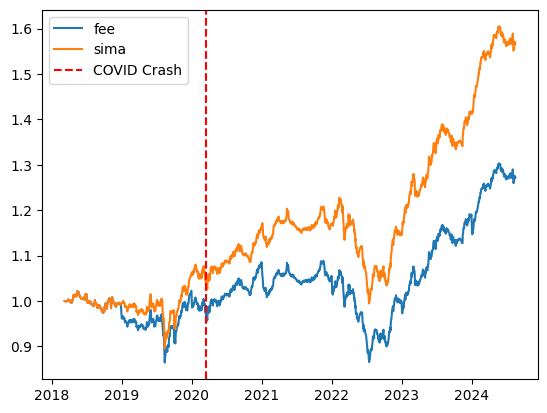

In [84]:
timeseries_cite = (df_cita+1).cumprod()
# df_cita
plt.plot(pd.to_datetime(timeseries_cite.index), timeseries_cite, label='fee')
plt.plot(pd.to_datetime(df.index), df['Citadella'], label='sima')

plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='COVID Crash')
# plt.title(title)
# plt.xlabel(x_label)
plt.legend()
# plt.ylabel(y_label)
# plt.grid(True)
plt.show()

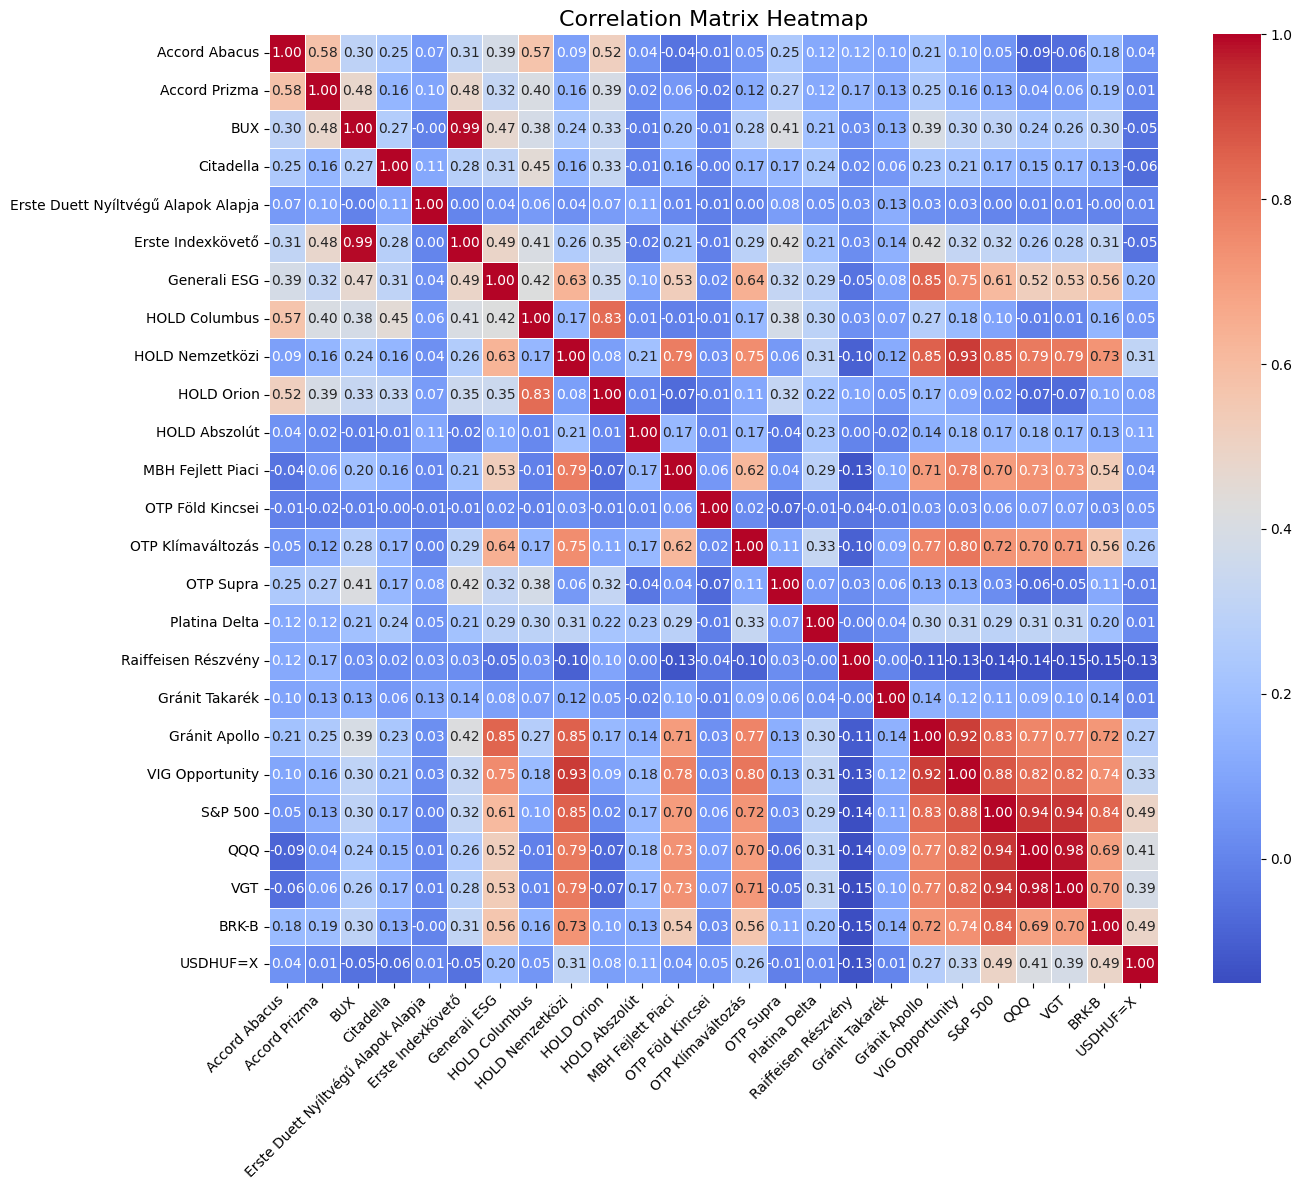

In [85]:
correlation_matrix = daily_returns.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

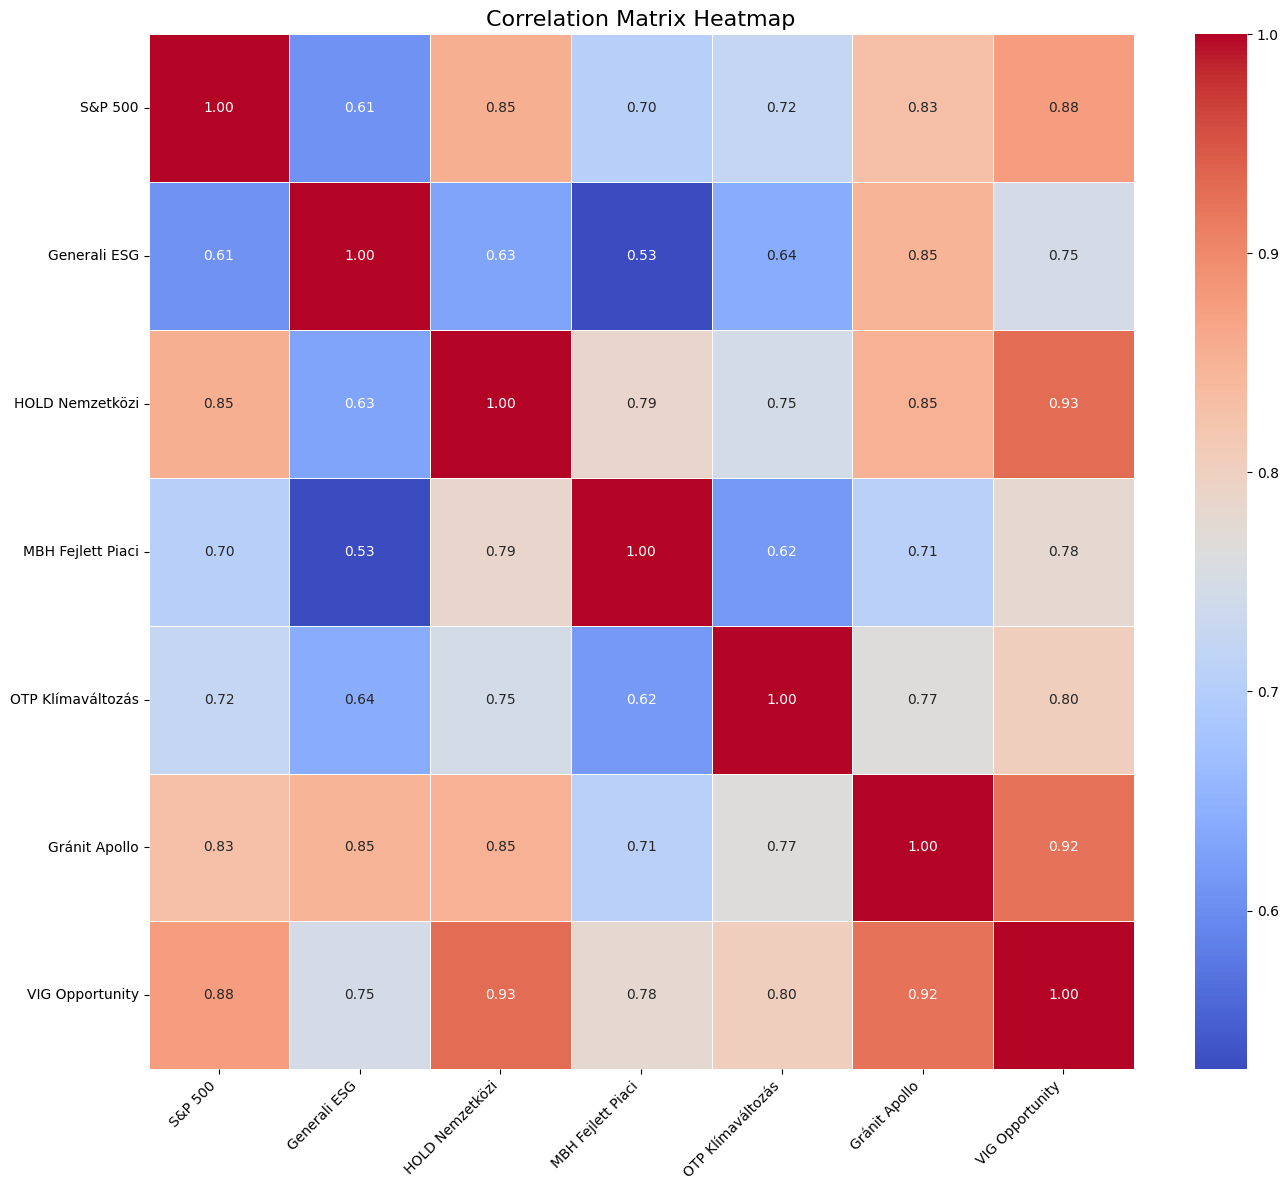

In [86]:
spy_correlated = ['S&P 500','Generali ESG', 'HOLD Nemzetközi', 'MBH Fejlett Piaci', 'OTP Klímaváltozás', 'Gránit Apollo','VIG Opportunity'  ]
correlation_matrix = daily_returns[spy_correlated].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

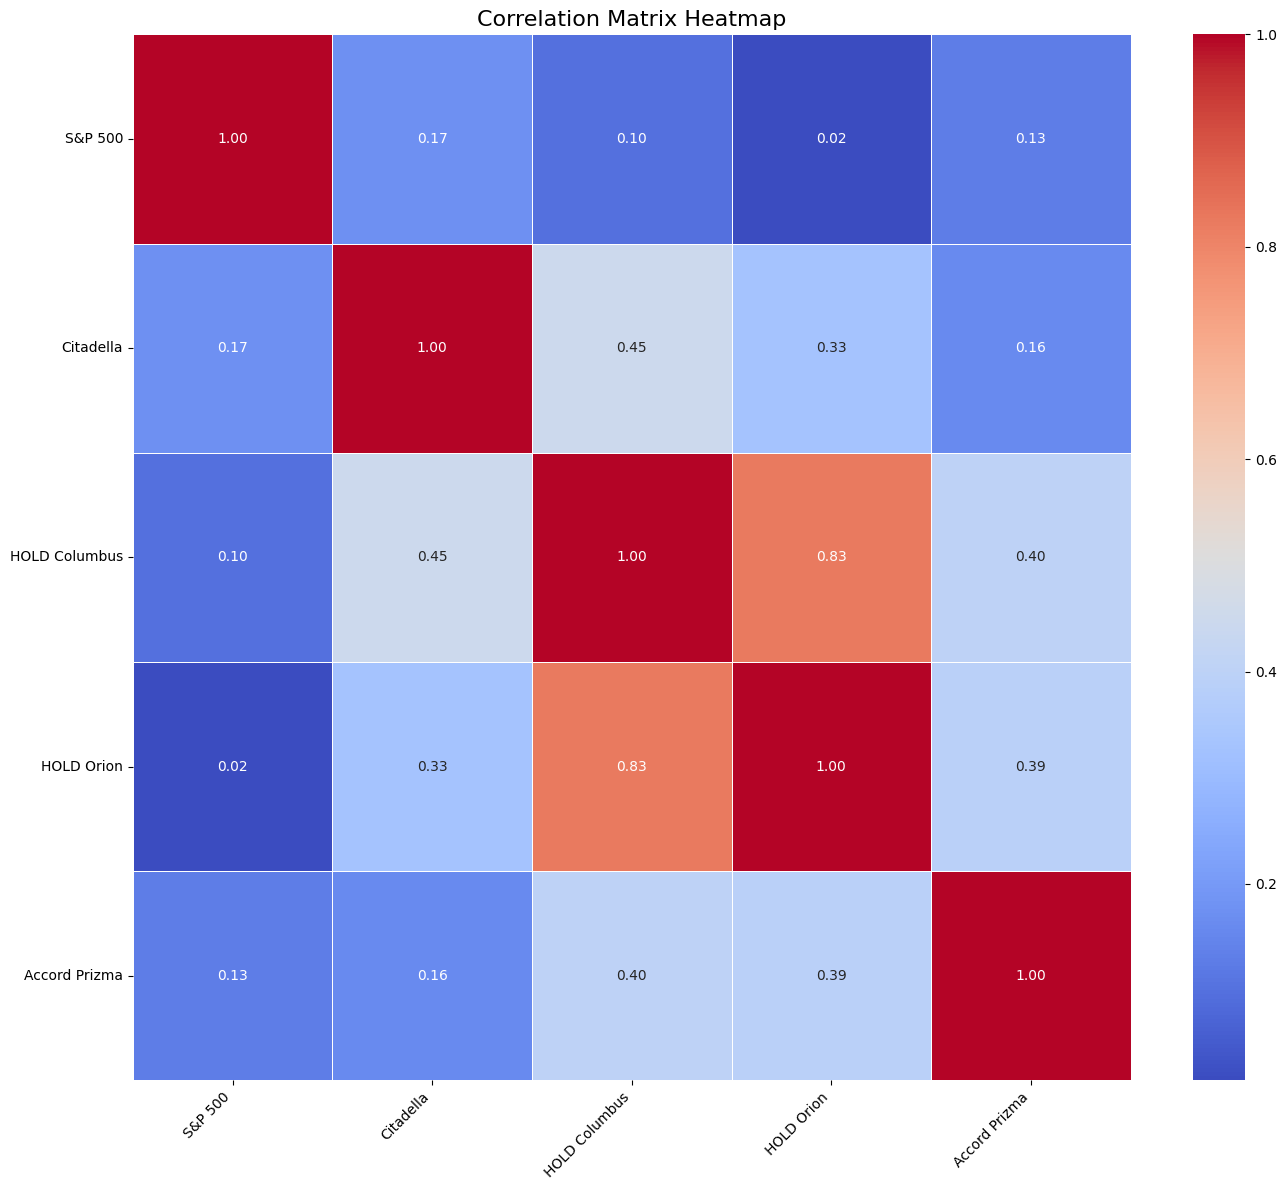

In [87]:
spy_correlated = ['S&P 500','Citadella', 'HOLD Columbus','HOLD Orion','Accord Prizma', ]
correlation_matrix = daily_returns[spy_correlated].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [88]:
def draw_decreasing_barchart(data, title, x_label, y_label):
    data = data.sort_values(ascending=False)
    plt.figure(figsize=(12, 8))
    data.plot(kind='bar', color='skyblue')
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
def draw_linchart(data, title, x_label, y_label):
    
    plt.figure(figsize=(12, 8))
    for column in data.columns:
        plt.plot(pd.to_datetime(data.index), data[column], label=column)

    plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='COVID Crash')
    plt.title(title)
    plt.xlabel(x_label)
    plt.legend()
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

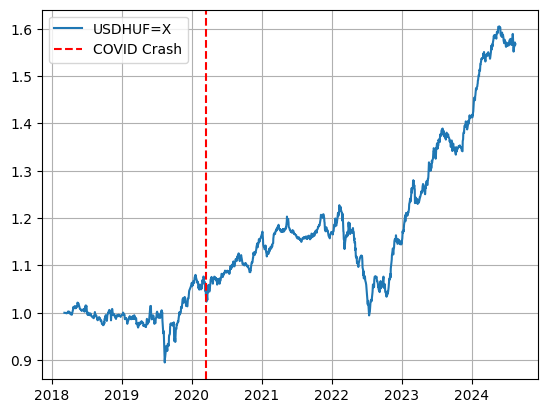

In [89]:
plt.plot(pd.to_datetime(df.index), df['Citadella'], label=column)

plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='COVID Crash')
# plt.title(title)
# plt.xlabel(x_label)
plt.legend()
# plt.ylabel(y_label)
plt.grid(True)
plt.show()

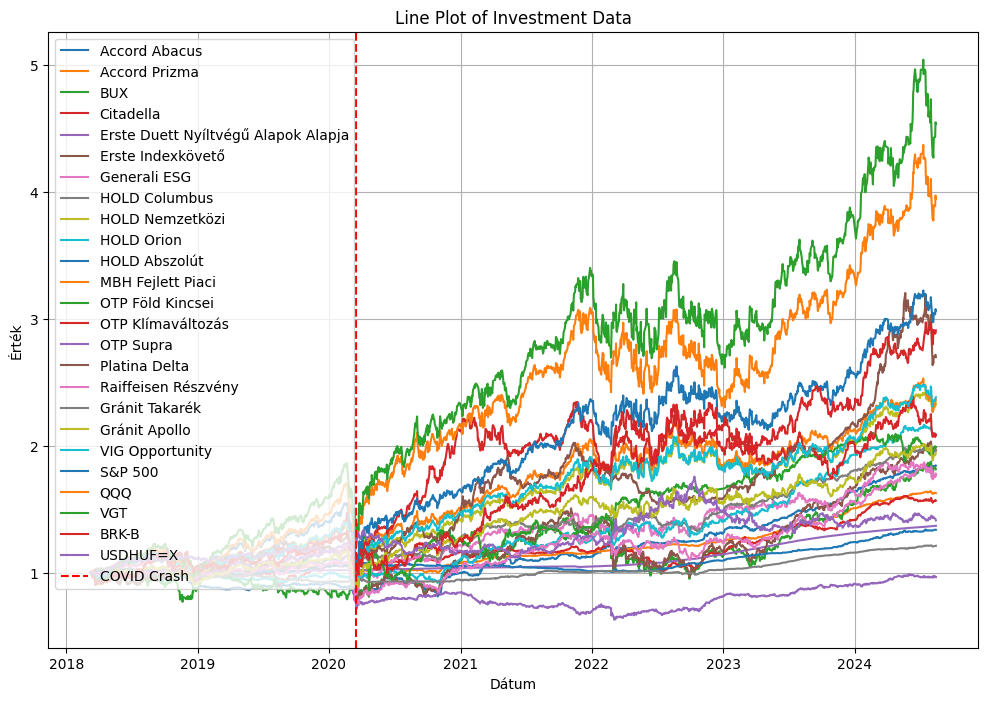

In [90]:
draw_linchart(df, 'Line Plot of Investment Data', 'Dátum', 'Érték' )

In [91]:
average_daily_returns = daily_returns.mean()
excess_returns = average_daily_returns - daily_risk_free_rate
std_dev_returns = daily_returns.std()
sharpe_ratios_daily = excess_returns / std_dev_returns
sharpe_ratios_annualized = sharpe_ratios_daily * np.sqrt(252)
sharpe_ratios_df = pd.DataFrame({
    'Average Daily Return': average_daily_returns,
    'Standard Deviation of Returns': std_dev_returns,
    'Daily Sharpe Ratio': sharpe_ratios_daily,
    'Annualized Sharpe Ratio': sharpe_ratios_annualized
})
sharpe_ratios_df

Average Daily Return  \
Accord Abacus                                    0.000412   
Accord Prizma                                    0.000317   
BUX                                              0.000478   
Citadella                                        0.000303   
Erste Duett Nyíltvégű Alapok Alapja              0.000204   
Erste Indexkövető                                0.000535   
Generali ESG                                     0.000427   
HOLD Columbus                                    0.000449   
HOLD Nemzetközi                                  0.000613   
HOLD Orion                                       0.000500   
HOLD Abszolút                                    0.000191   
MBH Fejlett Piaci                                0.000628   
OTP Föld Kincsei                                 0.000567   
OTP Klímaváltozás                                0.000570   
OTP Supra                                        0.000012   
Platina Delta                                    0.000681   
Raiffeisen Részvény                              0.000415   
Gránit Takarék                                   0.000127   
Gránit Apollo                                    0.000484   
VIG Opportunity                                  0.000636   
S&P 500                                          0.000833   
QQQ                                              0.001040   
VGT                                              0.001152   
BRK-B                                            0.000813   
USDHUF=X                                         0.000254   

                                     Standard Deviation of Returns  \
Accord Abacus                                             0.005568   
Accord Prizma                                             0.002008   
BUX                                                       0.013515   
Citadella                                                 0.004754   
Erste Duett Nyíltvégű Alapok Alapja                       0.000310   
Erste Indexkövető                                         0.013894   
Generali ESG                                              0.010677   
HOLD Columbus                                             0.005143   
HOLD Nemzetközi                                           0.011441   
HOLD Orion                                                0.006895   
HOLD Abszolút                                             0.001842   
MBH Fejlett Piaci                                         0.011871   
OTP Föld Kincsei                                          0.015353   
OTP Klímaváltozás                                         0.013747   
OTP Supra                                                 0.008173   
Platina Delta                                             0.008705   
Raiffeisen Részvény                                       0.009058   
Gránit Takarék                                            0.002021   
Gránit Apollo                                             0.010455   
VIG Opportunity                                           0.012067   
S&P 500                                                   0.014626   
QQQ                                                       0.017319   
VGT                                                       0.018516   
BRK-B                                                     0.015598   
USDHUF=X                                                  0.007808   

                                     Daily Sharpe Ratio  \
Accord Abacus                                  0.039188   
Accord Prizma                                  0.061548   
BUX                                            0.021077   
Citadella                                      0.022938   
Erste Duett Nyíltvégű Alapok Alapja            0.033218   
Erste Indexkövető                              0.024601   
Generali ESG                                   0.021904   
HOLD Columbus                                  0.049713   
HOLD Nemzetközi                                0.036683   
HOLD Orion                             

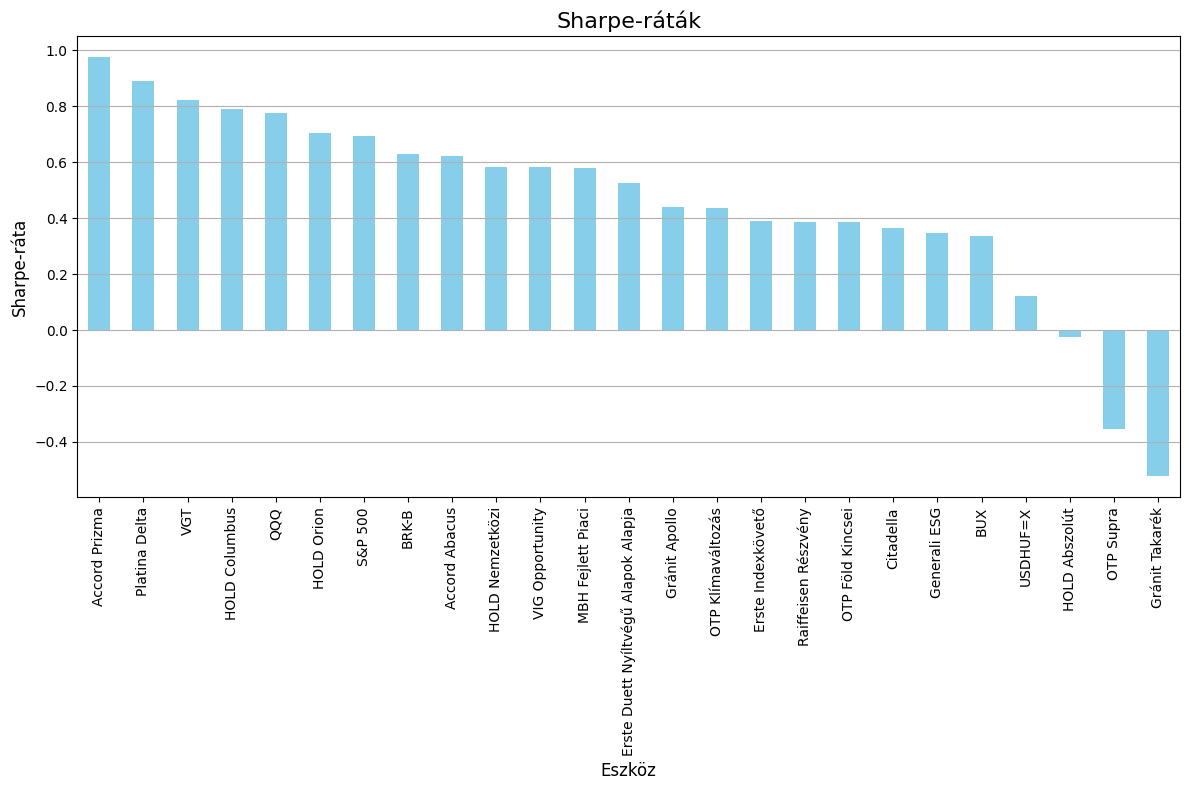

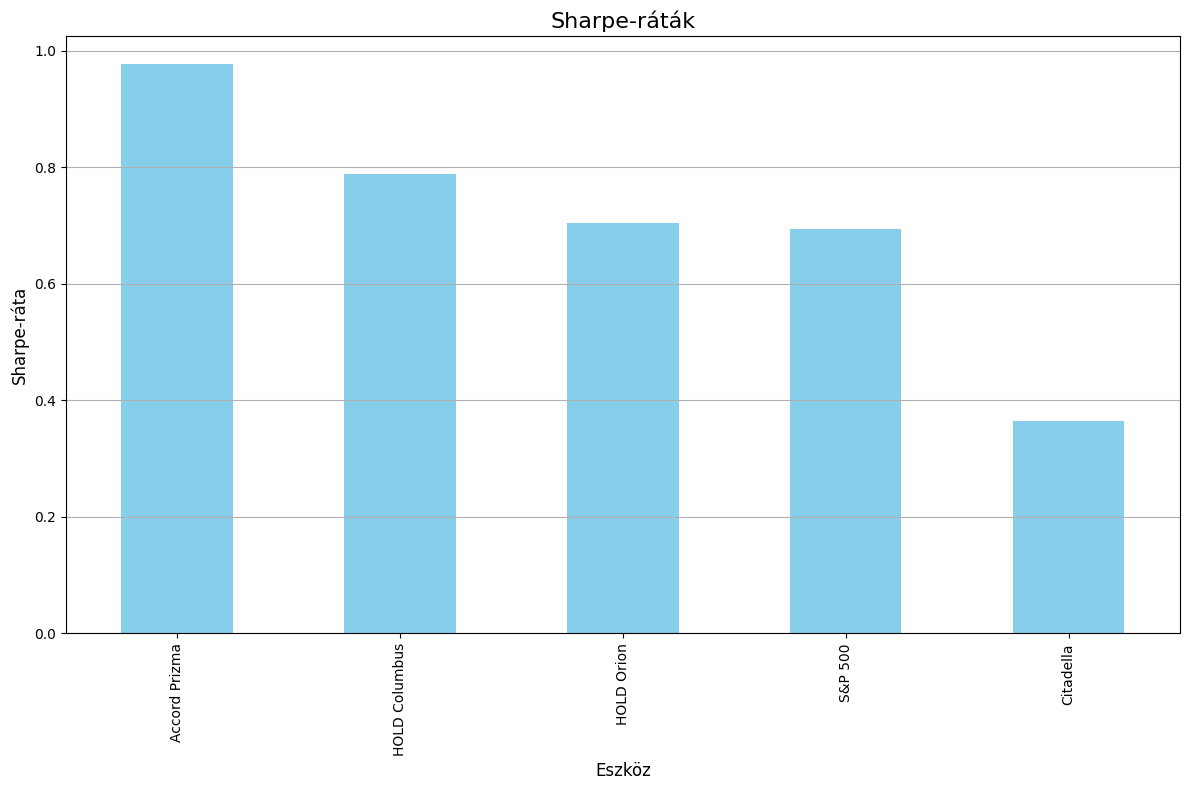

In [92]:
# Sort the Sharpe Ratios in descending order for the bar chart
sorted_sharpe_ratios = sharpe_ratios_df['Annualized Sharpe Ratio'].sort_values(ascending=False)
draw_decreasing_barchart(sorted_sharpe_ratios, 'Sharpe-ráták', 'Eszköz', 'Sharpe-ráta')

draw_decreasing_barchart(sorted_sharpe_ratios[spy_correlated], 'Sharpe-ráták', 'Eszköz', 'Sharpe-ráta')


Sortino Ratios:
 Accord Abacus                          0.887396
Accord Prizma                          1.332732
BUX                                    0.407585
Citadella                              0.490358
Erste Duett Nyíltvégű Alapok Alapja    1.064918
Erste Indexkövető                      0.464101
Generali ESG                           0.455145
HOLD Columbus                          1.102637
HOLD Nemzetközi                        0.756953
HOLD Orion                             0.981615
HOLD Abszolút                         -0.036218
MBH Fejlett Piaci                      0.767563
OTP Föld Kincsei                       0.446769
OTP Klímaváltozás                      0.601266
OTP Supra                             -0.370150
Platina Delta                          1.122931
Raiffeisen Részvény                    0.478316
Gránit Takarék                        -0.663959
Gránit Apollo                          0.582249
VIG Opportunity                        0.740761
S&P 500                

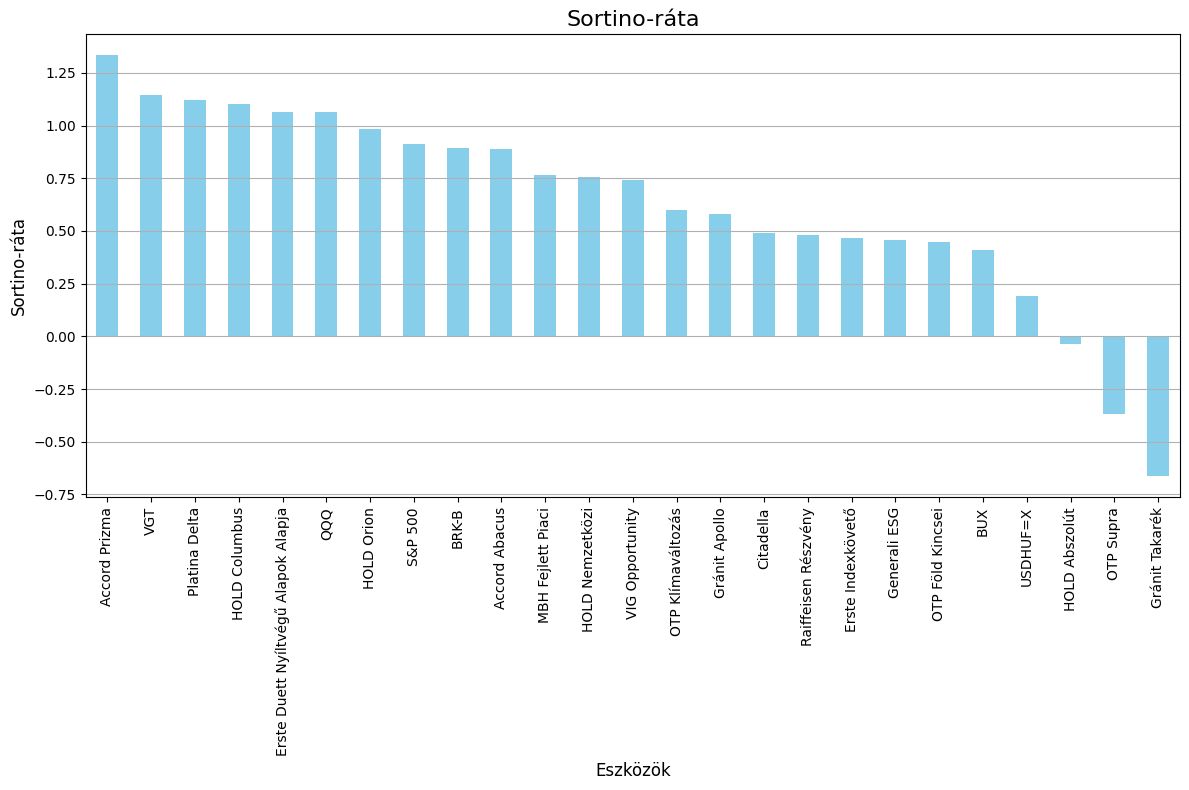

Treynor Ratios:
 Accord Abacus                          0.011506
Accord Prizma                          0.006923
BUX                                    0.001019
Citadella                              0.001926
Erste Duett Nyíltvégű Alapok Alapja    0.248879
Erste Indexkövető                      0.001122
Generali ESG                           0.000529
HOLD Columbus                          0.007329
HOLD Nemzetközi                        0.000627
HOLD Orion                             0.042764
HOLD Abszolút                         -0.000138
MBH Fejlett Piaci                      0.000759
OTP Föld Kincsei                       0.005988
OTP Klímaváltozás                      0.000552
OTP Supra                             -0.012398
Platina Delta                          0.002777
Raiffeisen Részvény                   -0.002484
Gránit Takarék                        -0.004465
Gránit Apollo                          0.000490
VIG Opportunity                        0.000611
S&P 500                

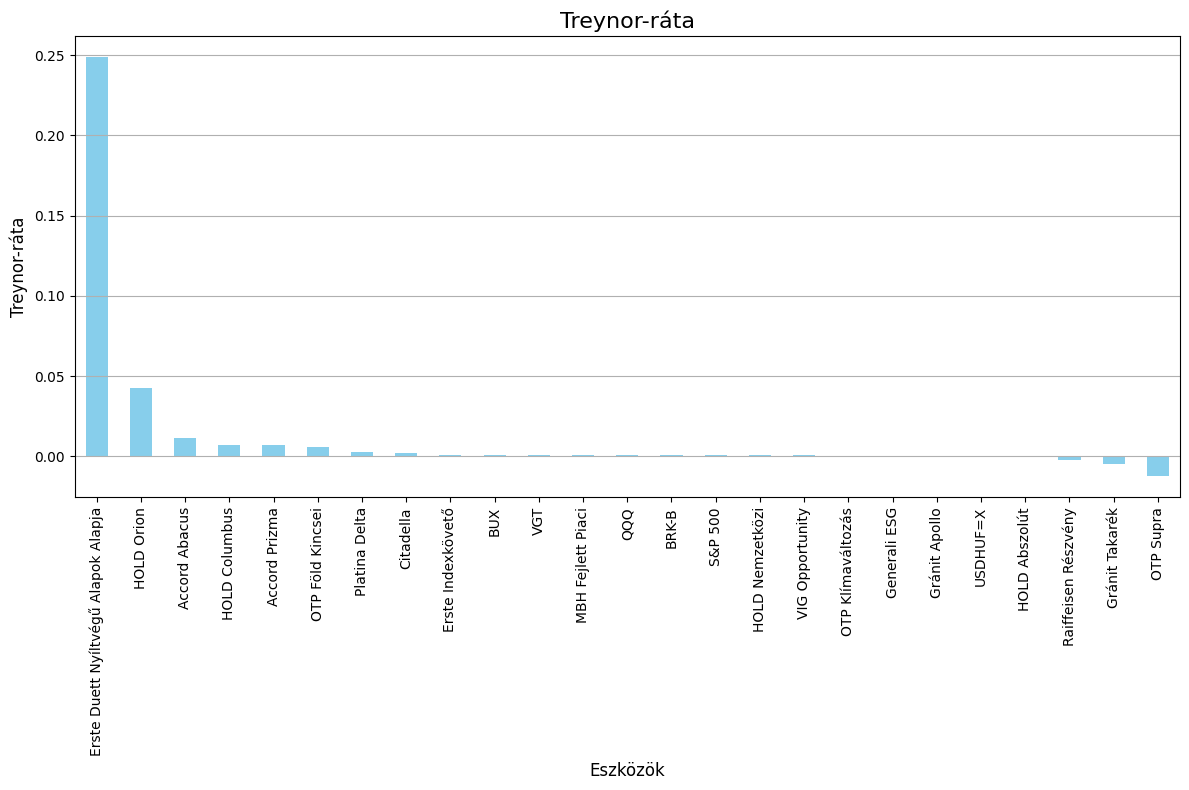

In [93]:
def sortino_ratio(returns, target=0):
    excess_returns = returns - target
    downside_deviation = np.std(excess_returns[excess_returns < target])
    sortino_ratio = np.mean(excess_returns) / downside_deviation
    sortino_ratio_annualized = sortino_ratio * np.sqrt(252)
    
    return sortino_ratio_annualized
sortino_ratios = daily_returns.apply(sortino_ratio, target=daily_risk_free_rate)
print("Sortino Ratios:\n", sortino_ratios)
draw_decreasing_barchart(sortino_ratios, 'Sortino-ráta', 'Eszközök', 'Sortino-ráta')

def treynor_ratio(returns, market_returns, beta, daily_risk_free_rate):
    excess_returns = np.mean(returns) - daily_risk_free_rate
    treynor_ratio = excess_returns / beta
    return treynor_ratio

market_returns = daily_returns[benchmark]
betas = daily_returns.apply(lambda x: np.cov(x, market_returns)[0, 1] / np.var(market_returns))
treynor_ratios = daily_returns.apply(lambda x: treynor_ratio(x, market_returns, betas[x.name], daily_risk_free_rate))
print("Treynor Ratios:\n", treynor_ratios)
draw_decreasing_barchart(treynor_ratios, 'Treynor-ráta', 'Eszközök', 'Treynor-ráta')


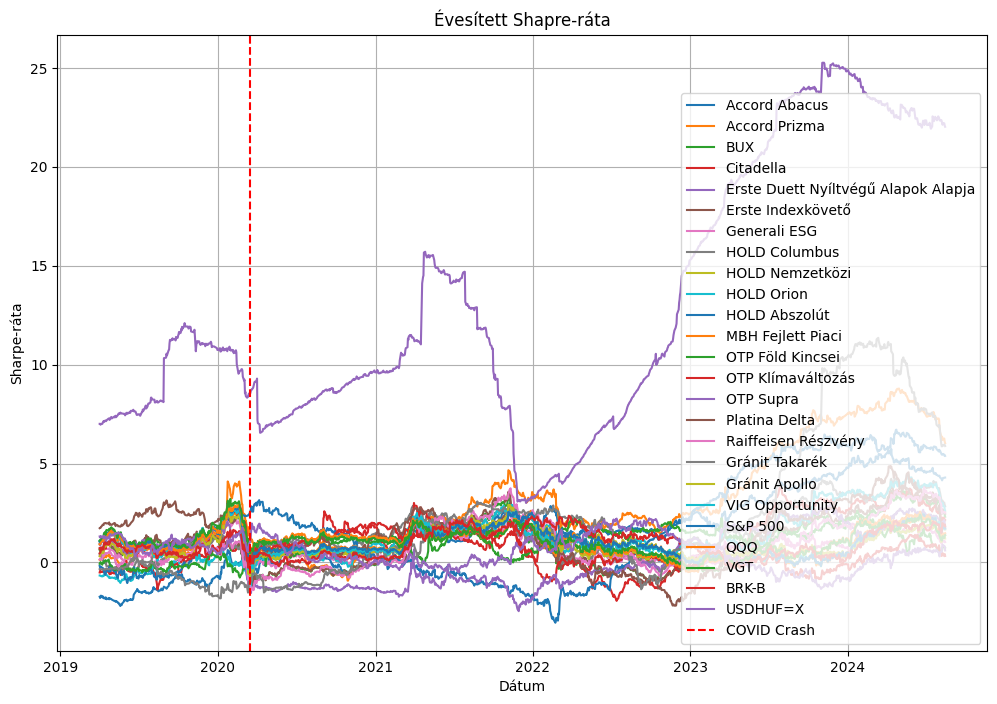

In [94]:
window_size = 252
rolling_sharpe_ratios = (
    daily_returns.rolling(window=window_size).mean() / 
    daily_returns.rolling(window=window_size).std()
) * np.sqrt(252)
draw_linchart(rolling_sharpe_ratios, 'Évesített Shapre-ráta', 'Dátum', 'Sharpe-ráta')


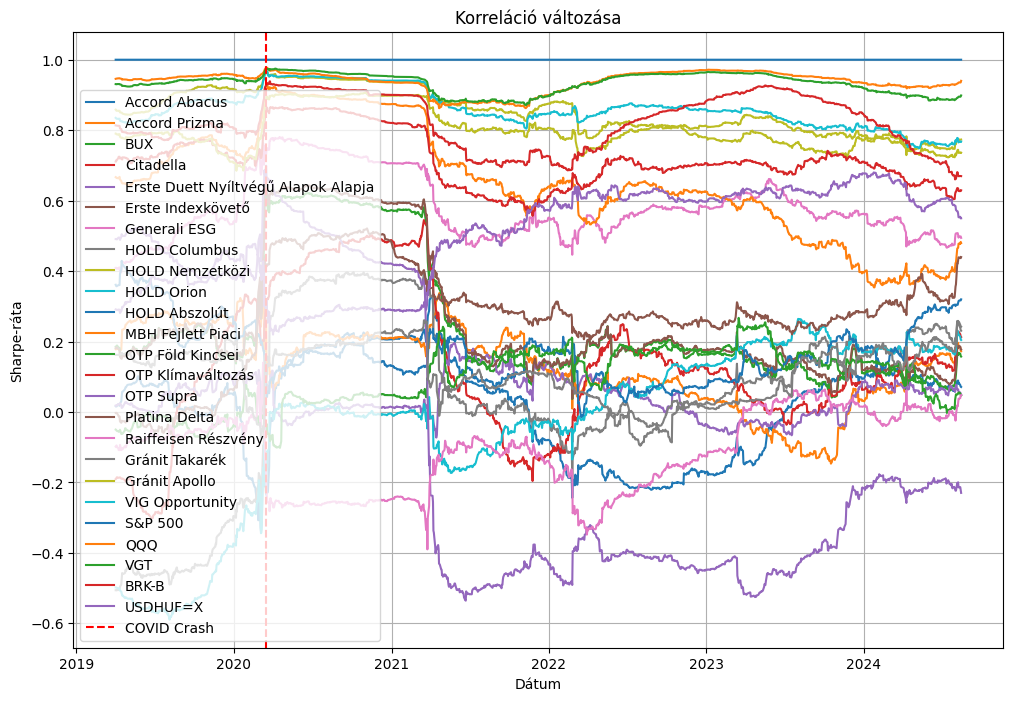

In [95]:
rolling_correlations = daily_returns.rolling(window=window_size).corr(daily_returns[benchmark])
draw_linchart(rolling_correlations, 'Korreláció változása', 'Dátum', 'Sharpe-ráta')


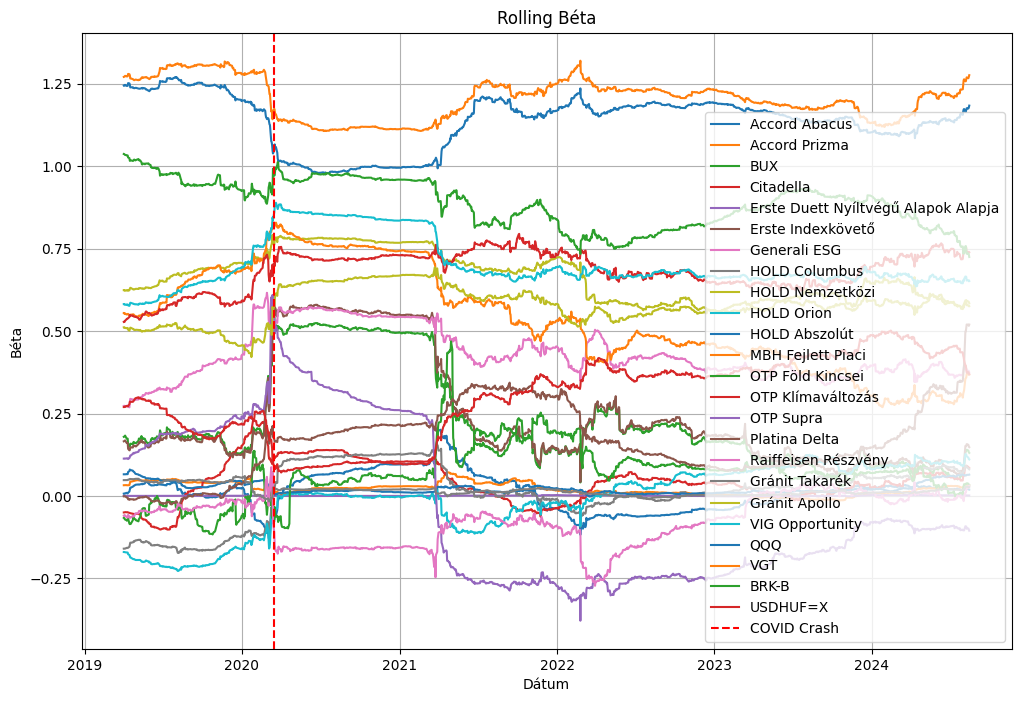

In [96]:
benchmark_returns = daily_returns[benchmark]
window_size = 252
betas = pd.DataFrame(index=daily_returns.index)
for column in daily_returns.columns:
    if column != benchmark: 
        rolling_covariance = daily_returns[column].rolling(window=window_size).cov(benchmark_returns)
        rolling_variance = benchmark_returns.rolling(window=window_size).var()
        rolling_beta = rolling_covariance / rolling_variance
        betas[column] = rolling_beta    
draw_linchart(betas, 'Rolling Béta', 'Dátum', 'Béta')


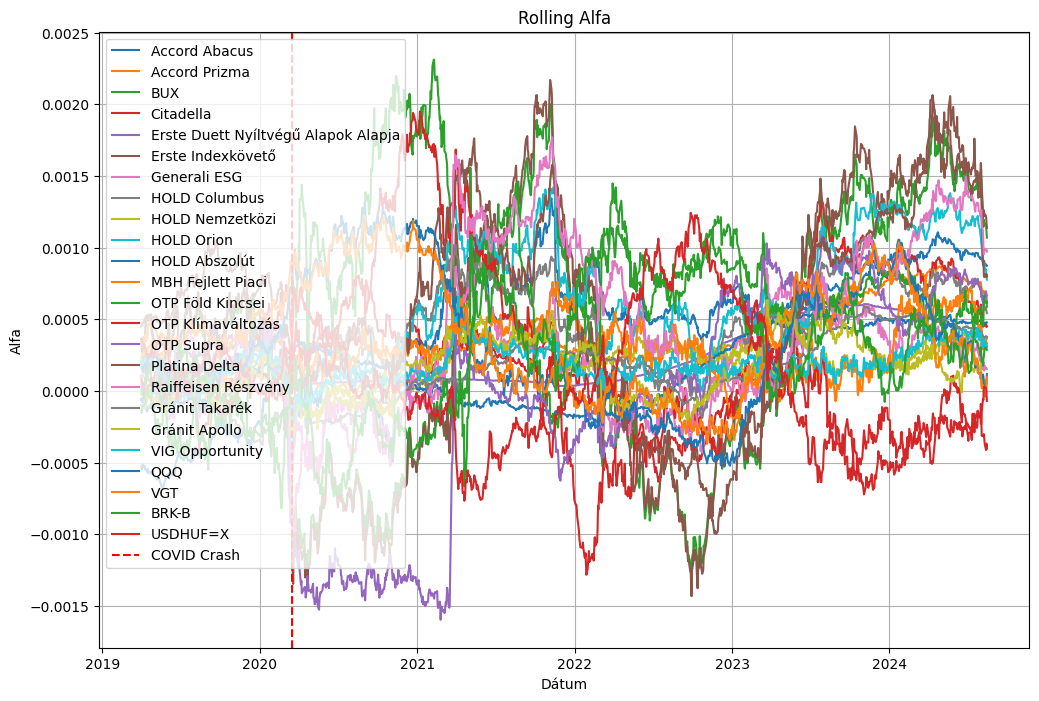

In [97]:
alphas = pd.DataFrame(index=daily_returns.index)
for column in daily_returns.columns:
    if column != benchmark:  # Skip the benchmark itself
        rolling_covariance = daily_returns[column].rolling(window=window_size).cov(benchmark_returns)
        rolling_variance = benchmark_returns.rolling(window=window_size).var()
        rolling_beta = rolling_covariance / rolling_variance
        expected_returns = rolling_beta * (benchmark_returns.rolling(window=window_size).mean() - daily_risk_free_rate)
        rolling_alpha = daily_returns[column].rolling(window=window_size).mean() - expected_returns
        alphas[column] = rolling_alpha
draw_linchart(alphas, 'Rolling Alfa', 'Dátum', 'Alfa')

OTP Föld Kincsei                       0.000649
Platina Delta                          0.000578
HOLD Orion                             0.000574
Raiffeisen Részvény                    0.000472
HOLD Columbus                          0.000456
Accord Abacus                          0.000426
VGT                                    0.000409
Erste Indexkövető                      0.000367
QQQ                                    0.000355
BUX                                    0.000319
Accord Prizma                          0.000301
MBH Fejlett Piaci                      0.000295
Citadella                              0.000283
BRK-B                                  0.000265
Erste Duett Nyíltvégű Alapok Alapja    0.000209
VIG Opportunity                        0.000180
Generali ESG                           0.000178
HOLD Nemzetközi                        0.000176
OTP Klímaváltozás                      0.000175
HOLD Abszolút                          0.000156
Gránit Apollo                          0

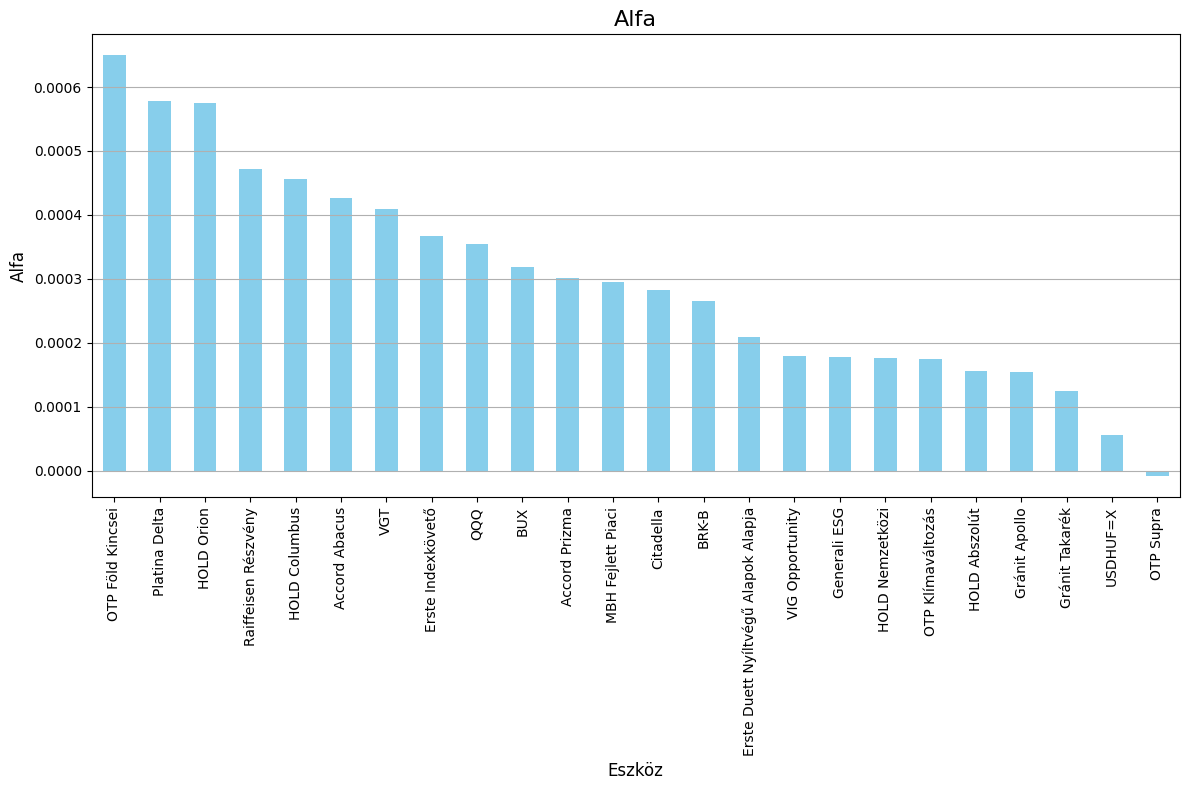

In [98]:
mean_alphas = alphas.mean()
mean_alphas = mean_alphas.sort_values(ascending=False)
print(mean_alphas)
draw_decreasing_barchart(mean_alphas, 'Alfa', 'Eszköz', 'Alfa')

C:\Users\takat\AppData\Local\Temp\ipykernel_24496\3352012754.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = sch.linkage(distance_matrix, method='average')


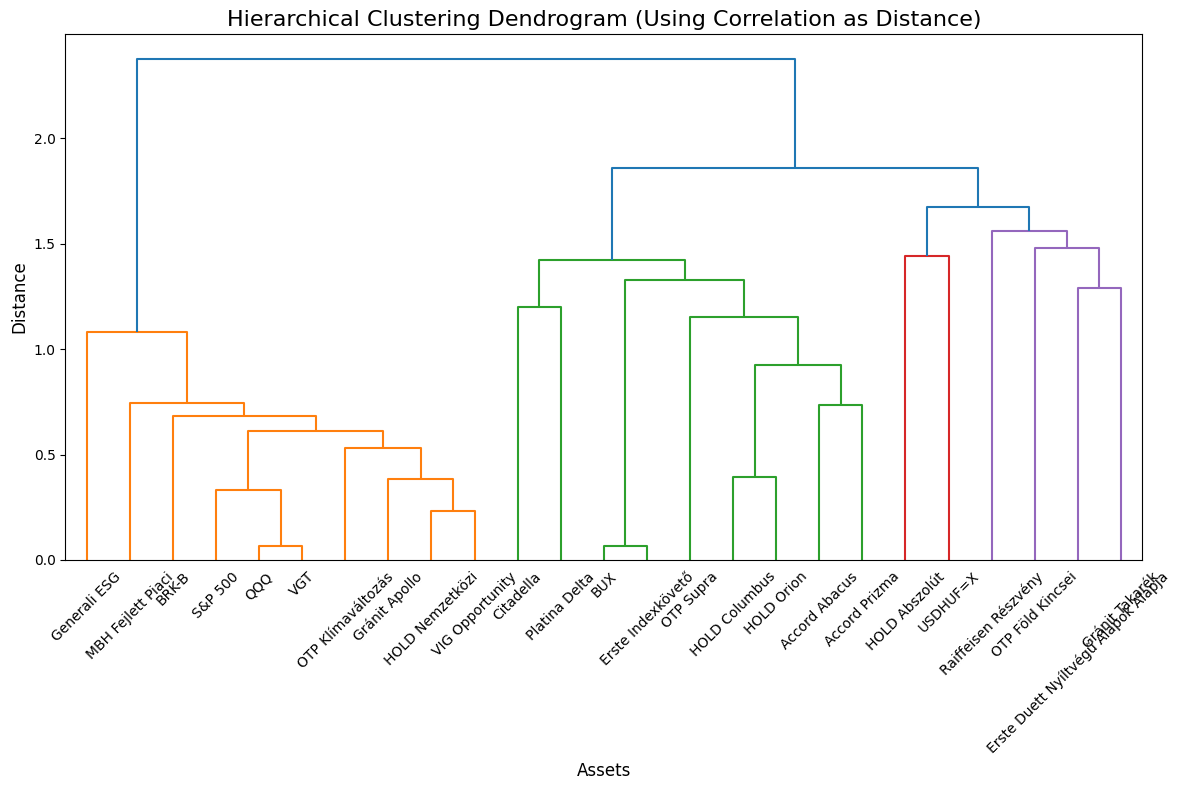

In [99]:
correlation_matrix = daily_returns.corr()
distance_matrix = 1 - correlation_matrix
linked = sch.linkage(distance_matrix, method='average')
plt.figure(figsize=(12, 8))
sch.dendrogram(linked, labels=correlation_matrix.columns, orientation='top')
plt.title('Hierarchical Clustering Dendrogram (Using Correlation as Distance)', fontsize=16)
plt.xlabel('Assets', fontsize=12, )
plt.xticks(rotation=45,)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

In [100]:
df.index = pd.to_datetime(df.index)
yearly_returns = df.resample('Y').last().pct_change().dropna()
average_yearly_returns = yearly_returns.mean()
std_dev_yearly_returns = yearly_returns.std()
sharpe_ratios_yearly = (average_yearly_returns - annual_risk_free_rate) / std_dev_yearly_returns
sharpe_ratios_yearly_df = pd.DataFrame({
    'Average Yearly Return': average_yearly_returns,
    'Standard Deviation of Yearly Returns': std_dev_yearly_returns,
    'Yearly Sharpe Ratio': sharpe_ratios_yearly
})
sharpe_ratios_yearly_df

C:\Users\takat\AppData\Local\Temp\ipykernel_24496\4291094125.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_returns = df.resample('Y').last().pct_change().dropna()


Average Yearly Return  \
Accord Abacus                                     0.133672   
Accord Prizma                                     0.088753   
BUX                                               0.115781   
Citadella                                         0.081995   
Erste Duett Nyíltvégű Alapok Alapja               0.053594   
Erste Indexkövető                                 0.131673   
Generali ESG                                      0.117855   
HOLD Columbus                                     0.116561   
HOLD Nemzetközi                                   0.158810   
HOLD Orion                                        0.140063   
HOLD Abszolút                                     0.051752   
MBH Fejlett Piaci                                 0.169000   
OTP Föld Kincsei                                  0.162493   
OTP Klímaváltozás                                 0.168870   
OTP Supra                                         0.021465   
Platina Delta                                     0.186191   
Raiffeisen Részvény                               0.114377   
Gránit Takarék                                    0.037101   
Gránit Apollo                                     0.137436   
VIG Opportunity                                   0.165182   
S&P 500                                           0.215307   
QQQ                                               0.290128   
VGT                                               0.314965   
BRK-B                                             0.191670   
USDHUF=X                                          0.043779   

                                     Standard Deviation of Yearly Returns  \
Accord Abacus                                                    0.071713   
Accord Prizma                                                    0.064767   
BUX                                                              0.195009   
Citadella                                                        0.090888   
Erste Duett Nyíltvégű Alapok Alapja                              0.055082   
Erste Indexkövető                                                0.212408   
Generali ESG                                                     0.098935   
HOLD Columbus                                                    0.058331   
HOLD Nemzetközi                                                  0.115184   
HOLD Orion                                                       0.121671   
HOLD Abszolút                                                    0.060960   
MBH Fejlett Piaci                                                0.155874   
OTP Föld Kincsei                                                 0.195969   
OTP Klímaváltozás                                                0.298573   
OTP Supra                                                        0.204224   
Platina Delta                                                    0.176353   
Raiffeisen Részvény                                              0.132079   
Gránit Takarék                                                   0.061413   
Gránit Apollo                                                    0.095629   
VIG Opportunity                                                  0.125674   
S&P 500                                                          0.173631   
QQQ                                                              0.276745   
VGT                                                              0.277879   
BRK-B                                                            0.142273   
USDHUF=X                                                         0.079045   

                                     Yearly Sharpe Ratio  
Accord Abacus                                   1.166759  
Accord Prizma                                   0.598339  
BUX                                             0.337325  
Citadella                                       0.352027  
Erste Duett Nyíltvégű Alapok Alapja             0.065241  
Erste Indexkövető                               0.384510  
Generali

C:\Users\takat\AppData\Local\Temp\ipykernel_24496\1685487539.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = df.resample('M').last().pct_change().dropna()


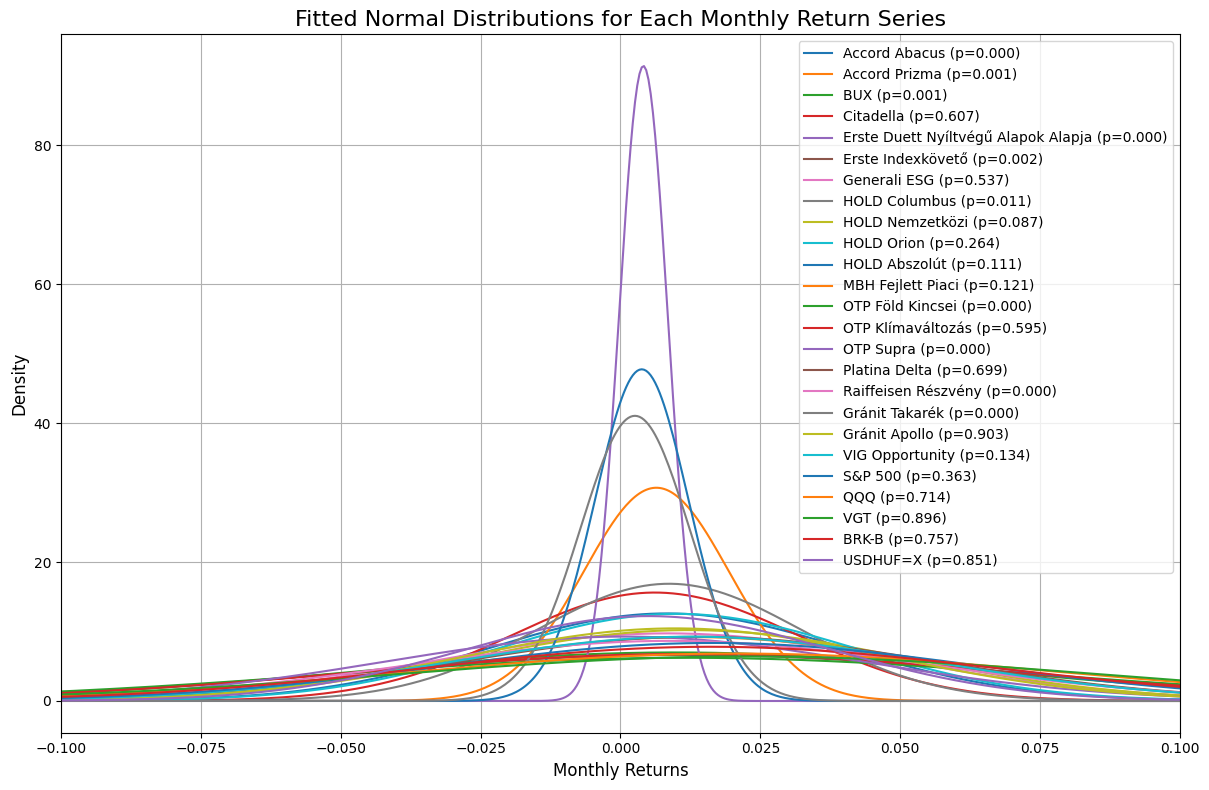

{'Accord Abacus': {'W-statistic': 0.8494007587432861,
  'p-value': 2.3475465127376083e-07,
  'is_normal': False},
 'Accord Prizma': {'W-statistic': 0.9324076771736145,
  'p-value': 0.0005066785961389542,
  'is_normal': False},
 'BUX': {'W-statistic': 0.9413540363311768,
  'p-value': 0.001458384795114398,
  'is_normal': False},
 'Citadella': {'W-statistic': 0.9867293834686279,
  'p-value': 0.6073905825614929,
  'is_normal': True},
 'Erste Duett Nyíltvégű Alapok Alapja': {'W-statistic': 0.8392123579978943,
  'p-value': 1.1005600697444606e-07,
  'is_normal': False},
 'Erste Indexkövető': {'W-statistic': 0.9417697191238403,
  'p-value': 0.0015340824611485004,
  'is_normal': False},
 'Generali ESG': {'W-statistic': 0.985588550567627,
  'p-value': 0.5367358922958374,
  'is_normal': True},
 'HOLD Columbus': {'W-statistic': 0.9570215344429016,
  'p-value': 0.01081500481814146,
  'is_normal': False},
 'HOLD Nemzetközi': {'W-statistic': 0.9719746708869934,
  'p-value': 0.08661096543073654,
  'is

In [101]:
monthly_returns = df.resample('M').last().pct_change().dropna()
shapiro_test_results_monthly = {}
x = np.linspace(-0.2, 0.2, 1000)
plt.figure(figsize=(12, 8))
for column in monthly_returns.columns:
    try:
        returns = monthly_returns[column].dropna()
        W, p_value = shapiro(returns)
        shapiro_test_results_monthly[column] = {
            'W-statistic': W,
            'p-value': p_value,
            'is_normal': p_value > 0.05
        }
        mu, std = norm.fit(returns)
        fitted_curve = norm.pdf(x, mu, std)
        plt.plot(x, fitted_curve, label=f"{column} (p={p_value:.3f})")
    except Exception as e:
        shapiro_test_results_monthly[column] = {
            'W-statistic': None,
            'p-value': None,
            'is_normal': False,
            'error': str(e)
        }
plt.title('Fitted Normal Distributions for Each Monthly Return Series', fontsize=16)
plt.xlabel('Monthly Returns', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(-0.1,0.1)
plt.show()
shapiro_test_results_monthly

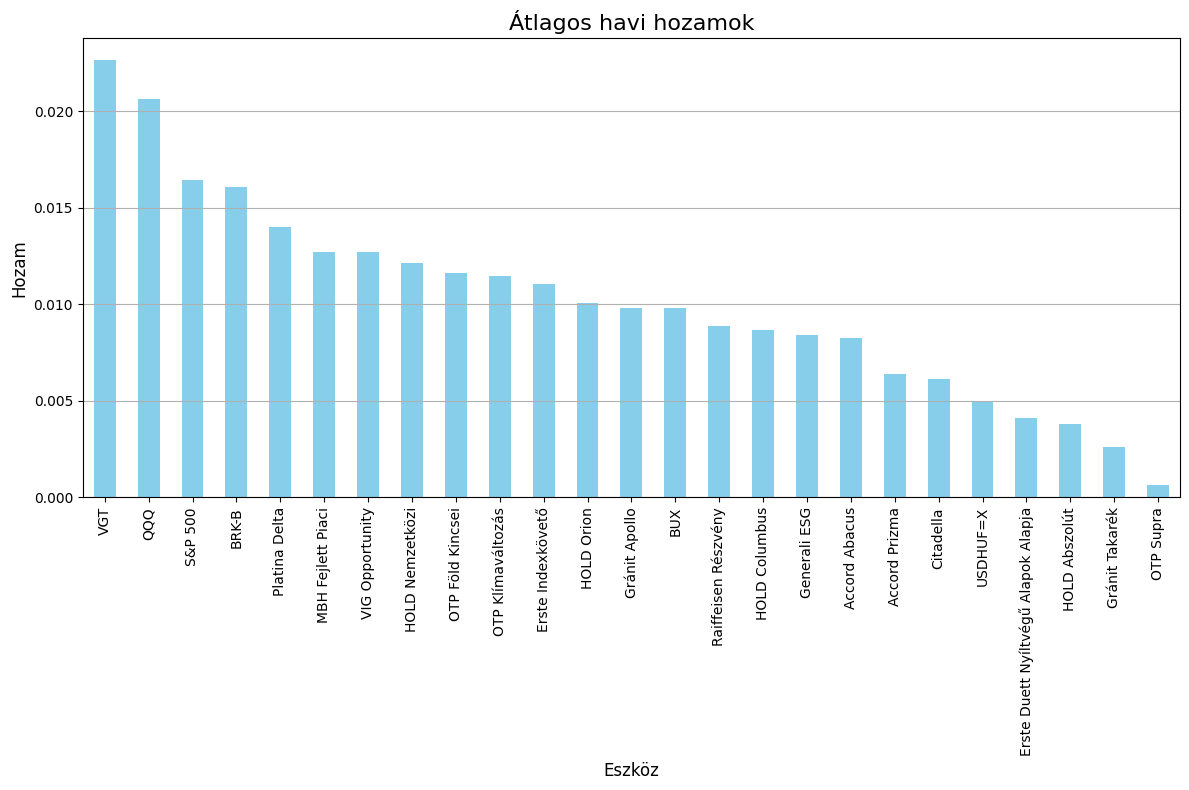

In [102]:
monthly_means = monthly_returns.mean()
draw_decreasing_barchart(monthly_means, 'Átlagos havi hozamok', 'Eszköz', 'Hozam')

Max Drawdowns:
 Accord Abacus                         -0.205121
Accord Prizma                         -0.054911
BUX                                   -0.360294
Citadella                             -0.189678
Erste Duett Nyíltvégű Alapok Alapja   -0.005795
Erste Indexkövető                     -0.390196
Generali ESG                          -0.311816
HOLD Columbus                         -0.114939
HOLD Nemzetközi                       -0.296252
HOLD Orion                            -0.150442
HOLD Abszolút                         -0.064689
MBH Fejlett Piaci                     -0.274339
OTP Föld Kincsei                      -0.379451
OTP Klímaváltozás                     -0.308348
OTP Supra                             -0.466067
Platina Delta                         -0.240179
Raiffeisen Részvény                   -0.308788
Gránit Takarék                        -0.085298
Gránit Apollo                         -0.261444
VIG Opportunity                       -0.319097
S&P 500                 

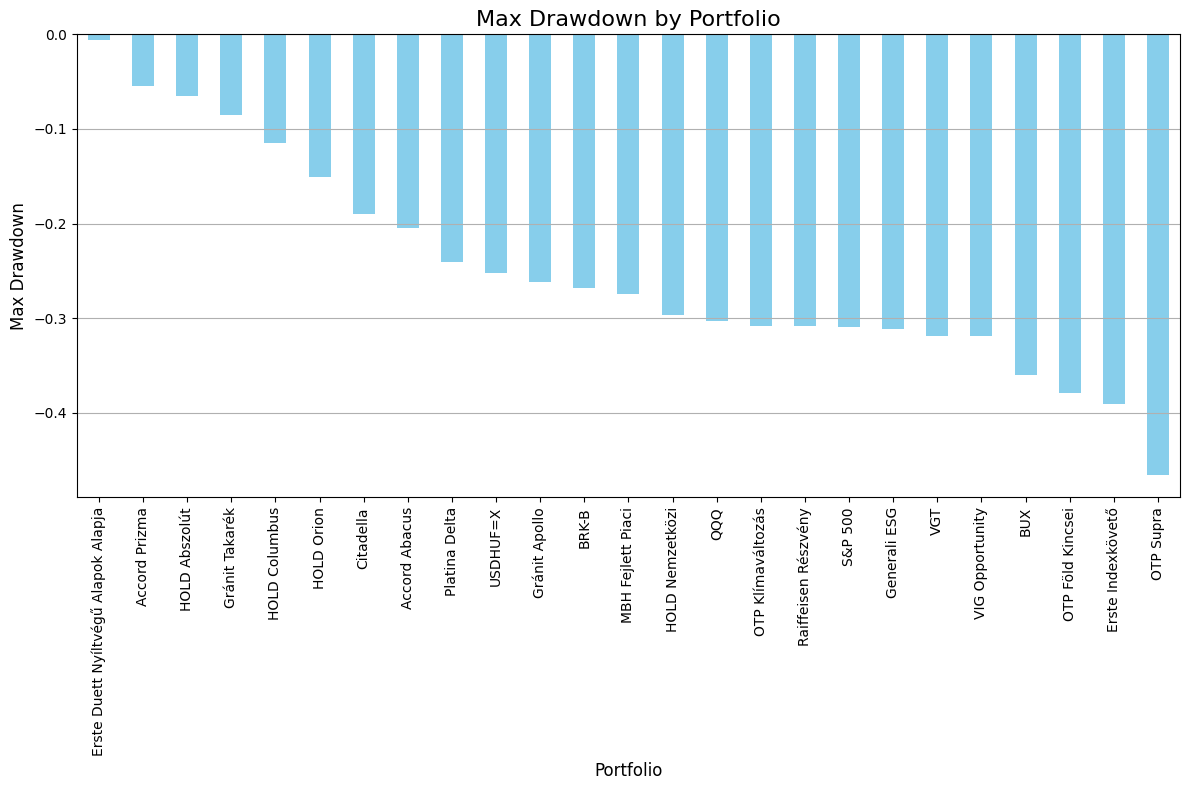

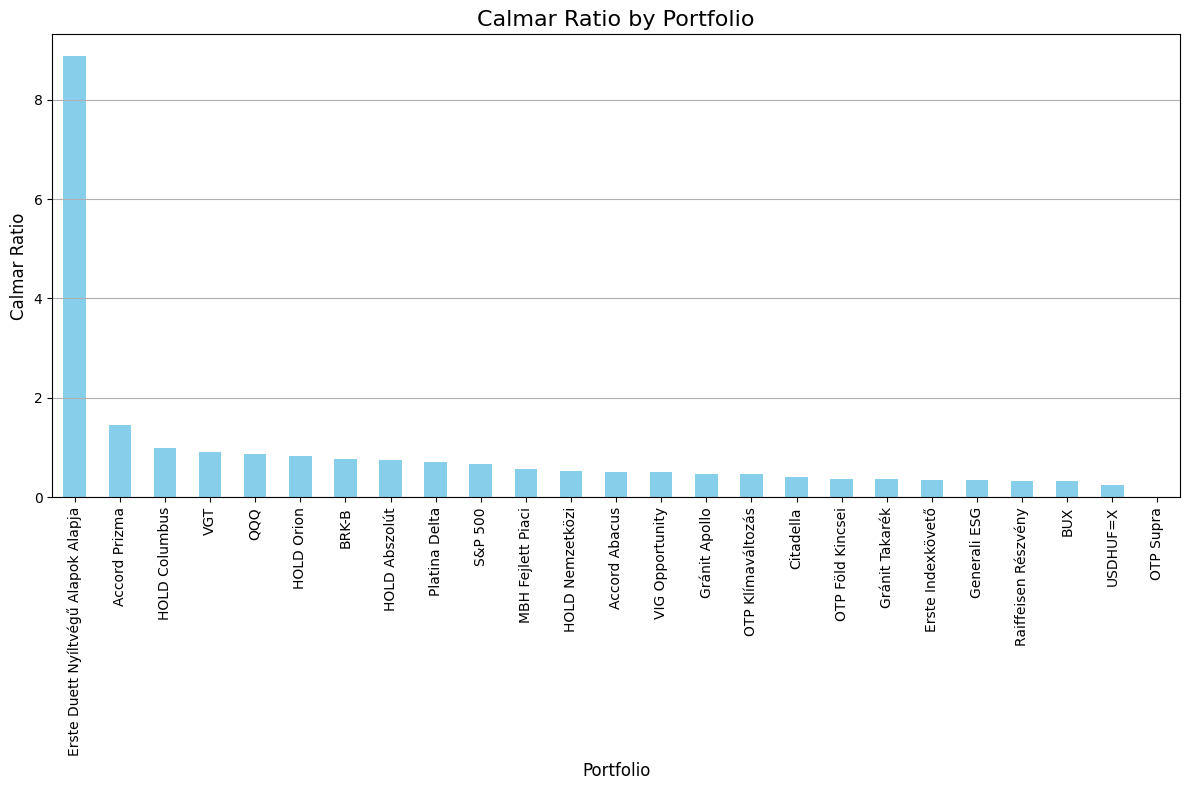

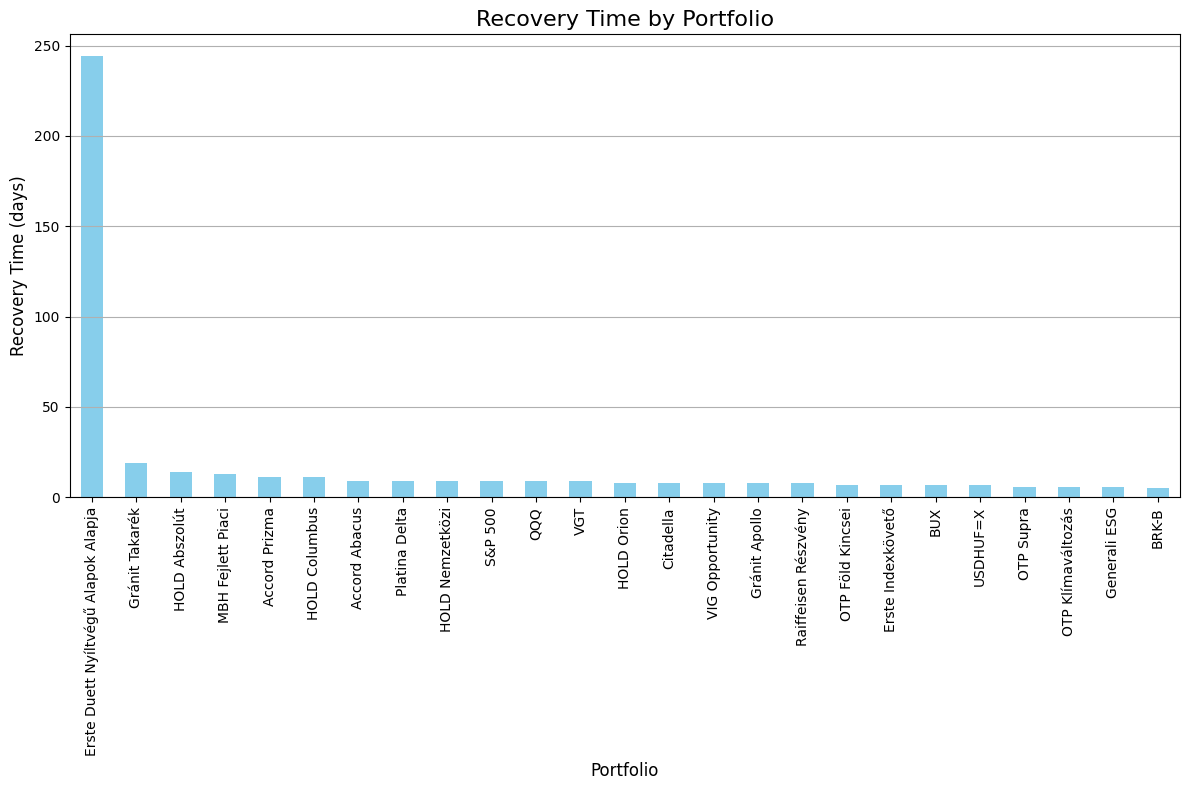

In [103]:

def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown_value = drawdown.min()
    return max_drawdown_value

# Apply the Max Drawdown function to each portfolio
max_drawdowns = daily_returns.apply(max_drawdown)
print("Max Drawdowns:\n", max_drawdowns)

# 2. Calmar Ratio
def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown)

# Calculate the annualized return for each portfolio
annualized_returns = daily_returns.mean() * 252

# Apply the Calmar Ratio function to each portfolio
calmar_ratios = pd.Series({col: calmar_ratio(annualized_returns[col], max_drawdowns[col]) for col in daily_returns.columns})
print("Calmar Ratios:\n", calmar_ratios)

# 3. Recovery Time Analysis
def recovery_time(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    recovery_time = (drawdown == 0).astype(int).groupby(drawdown.ne(0).cumsum()).cumsum().max()
    return recovery_time

# Apply the Recovery Time function to each portfolio
recovery_times = daily_returns.apply(recovery_time)
print("Recovery Times:\n", recovery_times)

# Visualization
draw_decreasing_barchart(max_drawdowns, "Max Drawdown by Portfolio", "Portfolio", "Max Drawdown")
draw_decreasing_barchart(calmar_ratios, "Calmar Ratio by Portfolio", "Portfolio", "Calmar Ratio")
draw_decreasing_barchart(recovery_times, "Recovery Time by Portfolio", "Portfolio", "Recovery Time (days)")


32


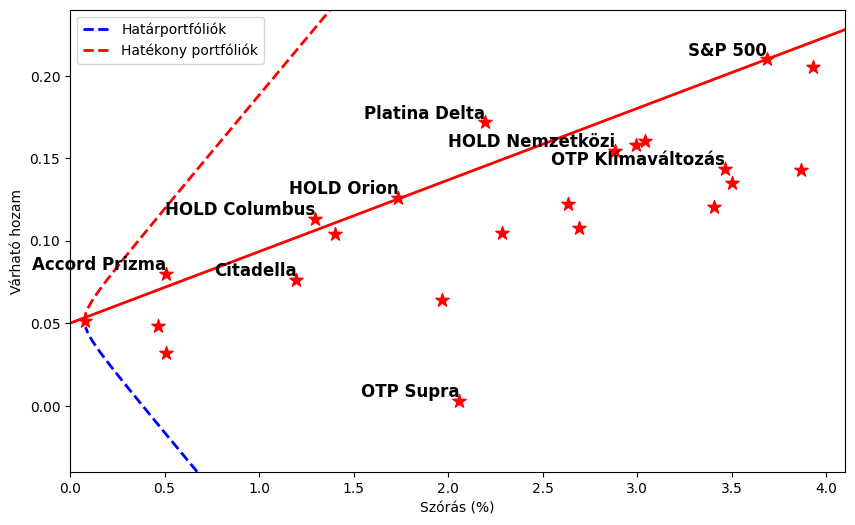

In [104]:
def calculate_returns(data):
    return data.pct_change().dropna()

def portfolio_statistics(weights, returns, covariance):
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * np.sqrt(252)  # Annualized volatility
    return portfolio_return, portfolio_volatility

def efficient_frontier(returns, num_portfolios, risk_free_rate):
    cov_matrix = returns.cov() * 252  # Annualize the covariance matrix
    expected_returns = returns.mean() * 252  # Annualize the returns
    num_assets = len(expected_returns)
    results = np.zeros((4, num_portfolios))

    for i in range(num_portfolios):
        weights = np.random.randn(num_assets)*1000
        weights /= np.sum(weights)        
        portfolio_return, portfolio_volatility = portfolio_statistics(weights, returns, cov_matrix)
        results[0,i] = portfolio_volatility
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_volatility  # Sharpe ratio

    return results

def minimum_variance_portfolio(cov_matrix):
    num_assets = len(cov_matrix)
    args = (cov_matrix,)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, cov: np.dot(weights.T, np.dot(cov, weights)),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def market_portfolio(returns, covariance, risk_free_rate):
    num_assets = len(returns)
    args = (returns, covariance, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, returns, cov, rf: -(np.dot(weights, returns) - rf) / np.sqrt(np.dot(weights.T, np.dot(cov, weights))),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def plot_efficient_frontier(results, exact_frontier_returns, exact_frontier_volatilities, 
                            mvp_return, mvp_volatility, market_return, market_volatility, 
                            risk_free_rate, min_x, max_x, min_y, max_y,returns, tickers, interesting):
    plt.figure(figsize=(10, 6))
    plt.xlim(min_x, max_x )  # Volatility range
    plt.ylim(min_y, max_y )  # Expected return range

    # plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='Blues', marker='o', s=7, alpha=1)
    # plt.colorbar(label='Sharpe-ráta')
    min_vol =  np.array(exact_frontier_volatilities).min()
    min_vol_pos = np.where(np.array(exact_frontier_volatilities) == min_vol)[0][0]
    print(min_vol_pos)
    plt.plot(exact_frontier_volatilities[:min_vol_pos], exact_frontier_returns[:min_vol_pos], 'b--', label='Határportfóliók', linewidth=2)
    
    plt.plot(exact_frontier_volatilities[min_vol_pos:], exact_frontier_returns[min_vol_pos:], 'r--', label='Hatékony portfóliók', linewidth=2)
    for tick in tickers:
        # if tick == benchmark:
        #    continue
        plt.scatter(np.sqrt(returns[tick].var())* 252, returns[tick].mean()* 252, color='red', marker='*', s=100, zorder=2, )
        if tick in interesting:
            plt.text(np.sqrt(returns[tick].var())* 252, returns[tick].mean()* 252, tick, fontsize=12, fontweight="bold", verticalalignment='bottom', horizontalalignment='right', color='black')
        
    sample2_volatility, sample2_return= np.sqrt(returns[benchmark].var())*252,returns[benchmark].mean()*252
    cal_x = np.linspace(min_x, max_x, 100)
    cal_y = risk_free_rate + (sample2_return - risk_free_rate) / sample2_volatility * cal_x
    plt.plot(cal_x, cal_y, color='red', linestyle='-', zorder=1, linewidth=2)
    plt.xlabel('Szórás (%)')
    plt.ylabel('Várható hozam')
    plt.legend()
interesting = ['Citadella', 'HOLD Columbus', 'HOLD Orion', 'Platina Delta', 'Accord Prizma', 'OTP Supra', 'HOLD Nemzetközi', 'OTP Klímaváltozás', benchmark ]
num_portfolios=10000
min_x, max_x = 0, 4.1
min_y, max_y = -0.04, 0.24
tickers = df.columns
returns = calculate_returns(df)
results = efficient_frontier(returns, num_portfolios, annual_risk_free_rate)
mu = returns.mean() * 252  
Sigma = returns.cov() * 252  
Sigma_inv = np.linalg.inv(Sigma)
ones = np.ones(len(mu))
U = np.vstack([mu, ones]).T
M = U.T@ (Sigma_inv@ U)
M_inv = np.linalg.inv(M)
desired_returns = np.linspace(min_y, max_y , 100)
exact_weights_list = []
exact_risk_list = []

for desired_return in desired_returns:
    u = np.array([desired_return, 1])
    w_star = Sigma_inv@ U@ M_inv@u
    # print(w_star)
    portfolio_risk = np.sqrt(np.dot(w_star.T, np.dot(Sigma, w_star))) * np.sqrt(252)
    exact_weights_list.append(w_star)
    exact_risk_list.append(portfolio_risk)

mvp_weights = minimum_variance_portfolio(Sigma)
mvp_return, mvp_volatility = portfolio_statistics(mvp_weights, returns, Sigma)
market_weights = market_portfolio(mu, Sigma, annual_risk_free_rate)
market_return, market_volatility = portfolio_statistics(market_weights, returns, Sigma)
plot_efficient_frontier(results, desired_returns, exact_risk_list, mvp_return, mvp_volatility, market_return, market_volatility, annual_risk_free_rate, min_x, max_x, min_y, max_y, returns, tickers, interesting)

plt.show()
